# load in fruits dataset

In [ ]:
from google.colab import drive

# Mount Google Drive to access files and folders
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/'
train_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/training/'
val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/validation/'
train_val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/train_val'
test_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_LDs/test/'

# Download and import libraries

In [ ]:
!pip install timm
!pip install optuna
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np

from optuna.trial import TrialState
import optuna
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

import imblearn.metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Create reproducible results

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


# Calculating pos weight

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train
train_dataset = ImageFolder(train_path)
train_targets = train_dataset.targets
train_class_counts = torch.bincount(torch.tensor(train_targets))

train_total_negative_samples = train_class_counts[0].item()
train_total_positive_samples = train_class_counts[1].item()

train_pos_weight = train_total_negative_samples / train_total_positive_samples

# Put class weight in tensor
train_pos_weight_tensor = torch.tensor(train_pos_weight)
train_pos_weight_tensor = train_pos_weight_tensor.to(DEVICE)
print(train_pos_weight_tensor)

tensor(0.4211, device='cuda:0')


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train_val dataset
train_val_dataset = ImageFolder(train_val_path)
train_val_targets = train_val_dataset.targets
train_val_class_counts = torch.bincount(torch.tensor(train_val_targets))

train_val_total_negative_samples = train_val_class_counts[0].item()
train_val_total_positive_samples = train_val_class_counts[1].item()

train_val_pos_weight = train_val_total_negative_samples / train_val_total_positive_samples

# Put class weight in tensor
train_val_pos_weight_tensor = torch.tensor(train_val_pos_weight)
train_val_pos_weight_tensor = train_val_pos_weight_tensor.to(DEVICE)
print(train_val_pos_weight_tensor)

tensor(0.4204, device='cuda:0')


# Basic CNN model

## Do hyperparameter tuning basic CNN model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):

  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])

  model = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.Linear(128 * 28 * 28, first_neuron),
      nn.ReLU(),
      nn.Dropout(p=drop_out),
      nn.Linear(first_neuron, 1)
  )

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(), # default = 0.5
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}%, "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f}, Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}%, "
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f}, Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-13 09:58:58,868] A new study created in memory with name: no-name-a5473736-ea37-44f5-98c8-666853906dff


Epoch [1/100], Train Loss: 0.7052, Train Accuracy: 0.4134%, Train specificity: 0.7702, Train sensitivity: 0.2632, Train g_mean: 0.4502% ----> Valid Loss: 0.3642, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.4115, Train Accuracy: 0.4444%, Train specificity: 0.6613, Train sensitivity: 0.3531, Train g_mean: 0.4832% ----> Valid Loss: 0.3640, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.4108, Train Accuracy: 0.2963%, Train specificity: 1.0000, Train sensitivity: 0.0000, Train g_mean: 0.0000% ----> Valid Loss: 0.3639, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [4/100], Train Loss: 0.4108, Train Accuracy: 0.2963%, Train specificity: 1.0000, Train sensitivity: 0.0000, Train g_mean: 0.0000% ----> Valid Loss: 0.3582, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, 

[I 2023-06-13 10:49:22,491] Trial 0 finished with value: 0.0 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.0016897620425988995, 'weightdecay': 0.0010683682861344901, 'use_pos_weight': True}. Best is trial 0 with value: 0.0.


Epoch [9/100], Train Loss: 0.4109, Train Accuracy: 0.2963%, Train specificity: 1.0000, Train sensitivity: 0.0000, Train g_mean: 0.0000% ----> Valid Loss: 0.3640, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Early stopping criterion met at epoch 8
Epoch [1/100], Train Loss: 0.9891, Train Accuracy: 0.6583%, Train specificity: 0.1815, Train sensitivity: 0.8591, Train g_mean: 0.3948% ----> Valid Loss: 0.4503, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6005, Train Accuracy: 0.7037%, Train specificity: 0.0081, Train sensitivity: 0.9966, Train g_mean: 0.0897% ----> Valid Loss: 0.5549, Valid Accuracy: 0.8186%, Valid specificity: 0.0976, Valid sensitivity: 0.9694, Valid g_mean: 0.3075
Epoch [3/100], Train Loss: 0.5823, Train Accuracy: 0.7049%, Train specificity: 0.0202, Train sensitivity: 0.9932, Train g_mean: 0.1415% ----> Valid Loss: 0.4720, Valid Accura

[I 2023-06-13 12:21:58,319] Trial 1 finished with value: 0.7099169533382993 and parameters: {'first_neuron': 512, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.00011211732955422756, 'weightdecay': 0.007825459884839169, 'use_pos_weight': False}. Best is trial 1 with value: 0.7099169533382993.


Epoch [18/100], Train Loss: 0.4903, Train Accuracy: 0.7778%, Train specificity: 0.5403, Train sensitivity: 0.8778, Train g_mean: 0.6887% ----> Valid Loss: 0.4845, Valid Accuracy: 0.7468%, Valid specificity: 0.6585, Valid sensitivity: 0.7653, Valid g_mean: 0.7099
Early stopping criterion met at epoch 17
Epoch [1/100], Train Loss: 0.4773, Train Accuracy: 0.5902%, Train specificity: 0.3226, Train sensitivity: 0.7029, Train g_mean: 0.4762% ----> Valid Loss: 0.3504, Valid Accuracy: 0.8186%, Valid specificity: 0.0000, Valid sensitivity: 0.9898, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.4045, Train Accuracy: 0.6057%, Train specificity: 0.5524, Train sensitivity: 0.6282, Train g_mean: 0.5891% ----> Valid Loss: 0.3434, Valid Accuracy: 0.6076%, Valid specificity: 0.7073, Valid sensitivity: 0.5867, Valid g_mean: 0.6442
Epoch [3/100], Train Loss: 0.3953, Train Accuracy: 0.5926%, Train specificity: 0.6089, Train sensitivity: 0.5857, Train g_mean: 0.5972% ----> Valid Loss: 0.3206, Valid Accu

[I 2023-06-13 13:33:58,812] Trial 2 finished with value: 0.7308191058363557 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.00021817637925385536, 'weightdecay': 0.0024049341076094704, 'use_pos_weight': True}. Best is trial 2 with value: 0.7308191058363557.


Epoch [14/100], Train Loss: 0.3411, Train Accuracy: 0.7121%, Train specificity: 0.7661, Train sensitivity: 0.6893, Train g_mean: 0.7267% ----> Valid Loss: 0.2767, Valid Accuracy: 0.7468%, Valid specificity: 0.7073, Valid sensitivity: 0.7551, Valid g_mean: 0.7308
Early stopping criterion met at epoch 13
Epoch [1/100], Train Loss: 0.6270, Train Accuracy: 0.4397%, Train specificity: 0.5685, Train sensitivity: 0.3854, Train g_mean: 0.4681% ----> Valid Loss: 0.3688, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.4116, Train Accuracy: 0.3214%, Train specificity: 0.8750, Train sensitivity: 0.0883, Train g_mean: 0.2779% ----> Valid Loss: 0.3629, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.4110, Train Accuracy: 0.3357%, Train specificity: 0.9113, Train sensitivity: 0.0934, Train g_mean: 0.2917% ----> Valid Loss: 0.3626, Valid Accu

[I 2023-06-13 14:24:58,947] Trial 3 finished with value: 0.0 and parameters: {'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.001398202089789502, 'weightdecay': 0.006510363224626807, 'use_pos_weight': True}. Best is trial 2 with value: 0.7308191058363557.


Epoch [9/100], Train Loss: 0.4108, Train Accuracy: 0.2963%, Train specificity: 1.0000, Train sensitivity: 0.0000, Train g_mean: 0.0000% ----> Valid Loss: 0.3622, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Early stopping criterion met at epoch 8
Epoch [1/100], Train Loss: 9.1084, Train Accuracy: 0.6703%, Train specificity: 0.0887, Train sensitivity: 0.9151, Train g_mean: 0.2849% ----> Valid Loss: 0.6285, Valid Accuracy: 0.8143%, Valid specificity: 0.0488, Valid sensitivity: 0.9745, Valid g_mean: 0.2180
Epoch [2/100], Train Loss: 0.6272, Train Accuracy: 0.7025%, Train specificity: 0.0000, Train sensitivity: 0.9983, Train g_mean: 0.0000% ----> Valid Loss: 0.4812, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.5946, Train Accuracy: 0.7025%, Train specificity: 0.0242, Train sensitivity: 0.9881, Train g_mean: 0.1546% ----> Valid Loss: 0.4312, Valid Accura

[I 2023-06-13 16:04:24,287] Trial 4 finished with value: 0.46492183706981366 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.00045923225366662455, 'weightdecay': 0.0079277862676131, 'use_pos_weight': False}. Best is trial 2 with value: 0.7308191058363557.


Epoch [18/100], Train Loss: 0.5488, Train Accuracy: 0.7455%, Train specificity: 0.4919, Train sensitivity: 0.8523, Train g_mean: 0.6475% ----> Valid Loss: 0.4089, Valid Accuracy: 0.8523%, Valid specificity: 0.2195, Valid sensitivity: 0.9847, Valid g_mean: 0.4649
Early stopping criterion met at epoch 17
Epoch [1/100], Train Loss: 0.7146, Train Accuracy: 0.6619%, Train specificity: 0.0444, Train sensitivity: 0.9219, Train g_mean: 0.2022% ----> Valid Loss: 0.4685, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.5950, Train Accuracy: 0.7013%, Train specificity: 0.0806, Train sensitivity: 0.9626, Train g_mean: 0.2786% ----> Valid Loss: 0.4291, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.5934, Train Accuracy: 0.7037%, Train specificity: 0.0000, Train sensitivity: 1.0000, Train g_mean: 0.0000% ----> Valid Loss: 0.4235, Valid Accu

[I 2023-06-13 16:31:42,376] Trial 5 pruned. 


Epoch [5/100], Train Loss: 0.5466, Train Accuracy: 0.7121%, Train specificity: 0.1331, Train sensitivity: 0.9559, Train g_mean: 0.3566% ----> Valid Loss: 0.4620, Valid Accuracy: 0.7764%, Valid specificity: 0.3171, Valid sensitivity: 0.8724, Valid g_mean: 0.5260
Epoch [1/100], Train Loss: 5.7836, Train Accuracy: 0.4922%, Train specificity: 0.5363, Train sensitivity: 0.4737, Train g_mean: 0.5040% ----> Valid Loss: 0.3618, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.4149, Train Accuracy: 0.4886%, Train specificity: 0.3992, Train sensitivity: 0.5263, Train g_mean: 0.4584% ----> Valid Loss: 0.3625, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.4444, Train Accuracy: 0.5627%, Train specificity: 0.2298, Train sensitivity: 0.7029, Train g_mean: 0.4019% ----> Valid Loss: 0.3555, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, 

[I 2023-06-13 17:00:07,227] Trial 6 pruned. 


Epoch [5/100], Train Loss: 0.4109, Train Accuracy: 0.6786%, Train specificity: 0.0282, Train sensitivity: 0.9525, Train g_mean: 0.1640% ----> Valid Loss: 0.3586, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [1/100], Train Loss: 8.7599, Train Accuracy: 0.3608%, Train specificity: 0.8427, Train sensitivity: 0.1579, Train g_mean: 0.3648% ----> Valid Loss: 0.3642, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.4112, Train Accuracy: 0.2963%, Train specificity: 1.0000, Train sensitivity: 0.0000, Train g_mean: 0.0000% ----> Valid Loss: 0.3652, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.4111, Train Accuracy: 0.3811%, Train specificity: 0.7177, Train sensitivity: 0.2394, Train g_mean: 0.4145% ----> Valid Loss: 0.3624, Valid Accuracy: 0.1730%, Valid specificity: 1.0000, 

[I 2023-06-13 17:27:56,624] Trial 7 pruned. 


Epoch [5/100], Train Loss: 0.4109, Train Accuracy: 0.5556%, Train specificity: 0.3589, Train sensitivity: 0.6384, Train g_mean: 0.4786% ----> Valid Loss: 0.3591, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [1/100], Train Loss: 0.6662, Train Accuracy: 0.6452%, Train specificity: 0.1331, Train sensitivity: 0.8608, Train g_mean: 0.3384% ----> Valid Loss: 0.4643, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.5704, Train Accuracy: 0.7037%, Train specificity: 0.0000, Train sensitivity: 1.0000, Train g_mean: 0.0000% ----> Valid Loss: 0.4233, Valid Accuracy: 0.8228%, Valid specificity: 0.0000, Valid sensitivity: 0.9949, Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.5440, Train Accuracy: 0.7192%, Train specificity: 0.2460, Train sensitivity: 0.9185, Train g_mean: 0.4753% ----> Valid Loss: 0.4056, Valid Accuracy: 0.8228%, Valid specificity: 0.0488, 

[I 2023-06-13 17:55:58,208] Trial 8 pruned. 


Epoch [5/100], Train Loss: 0.5222, Train Accuracy: 0.7360%, Train specificity: 0.3266, Train sensitivity: 0.9083, Train g_mean: 0.5447% ----> Valid Loss: 0.3899, Valid Accuracy: 0.8312%, Valid specificity: 0.2195, Valid sensitivity: 0.9592, Valid g_mean: 0.4589
Epoch [1/100], Train Loss: 0.9963, Train Accuracy: 0.6440%, Train specificity: 0.1532, Train sensitivity: 0.8506, Train g_mean: 0.3610% ----> Valid Loss: 0.4777, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6178, Train Accuracy: 0.7037%, Train specificity: 0.0000, Train sensitivity: 1.0000, Train g_mean: 0.0000% ----> Valid Loss: 0.5187, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.5813, Train Accuracy: 0.7025%, Train specificity: 0.0000, Train sensitivity: 0.9983, Train g_mean: 0.0000% ----> Valid Loss: 0.4396, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, 

[I 2023-06-13 18:23:17,023] Trial 9 pruned. 


Epoch [5/100], Train Loss: 0.5474, Train Accuracy: 0.7049%, Train specificity: 0.0040, Train sensitivity: 1.0000, Train g_mean: 0.0635% ----> Valid Loss: 0.4052, Valid Accuracy: 0.8270%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  5
  Number of complete trials:  5
Best trial:
  Value:  0.7308191058363557
  Params: 
    first_neuron: 256
    drop_out: 0
    optimizer: Adam
    lr: 0.00021817637925385536
    weightdecay: 0.0024049341076094704
    use_pos_weight: True


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.000000,2023-06-13 09:58:58.883148,2023-06-13 10:49:22.490914,0 days 00:50:23.607766,0.3,128,0.001690,Adam,True,0.001068,COMPLETE
1,1,0.709917,2023-06-13 10:49:22.492938,2023-06-13 12:21:58.319241,0 days 01:32:35.826303,0.0,512,0.000112,RMSprop,False,0.007825,COMPLETE
2,2,0.730819,2023-06-13 12:21:58.321036,2023-06-13 13:33:58.812557,0 days 01:12:00.491521,0.0,256,0.000218,Adam,True,0.002405,COMPLETE
3,3,0.000000,2023-06-13 13:33:58.814242,2023-06-13 14:24:58.946816,0 days 00:51:00.132574,0.5,256,0.001398,Adam,True,0.006510,COMPLETE
4,4,0.464922,2023-06-13 14:24:58.951683,2023-06-13 16:04:24.287375,0 days 01:39:25.335692,0.0,256,0.000459,RMSprop,False,0.007928,COMPLETE
5,5,0.310750,2023-06-13 16:04:24.293952,2023-06-13 16:31:42.375937,0 days 00:27:18.081985,0.0,512,0.000163,Adam,False,0.001575,PRUNED
6,6,0.000000,2023-06-13 16:31:42.377664,2023-06-13 17:00:07.227296,0 days 00:28:24.849632,0.5,256,0.008282,Adam,True,0.002334,PRUNED
7,7,0.000000,2023-06-13 17:00:07.231966,2023-06-13 17:27:56.624605,0 days 00:27:49.392639,0.3,768,0.009247,AdamW,True,0.001103,PRUNED
8,8,0.268423,2023-06-13 17:27:56.626481,2023-06-13 17:55:58.207892,0 days 00:28:01.581411,0.0,256,0.000270,AdamW,False,0.003129,PRUNED
9,9,0.000000,2023-06-13 17:55:58.209459,2023-06-13 18:23:17.023012,0 days 00:27:18.813553,0.3,256,0.000995,AdamW,False,0.004484,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

## Train the Basic CNN model with the best hyperparameters (on combined training and validation dataset

In [ ]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 256
best_dropout = 0.0
best_optimizer = 'Adam'
best_lr = 0.000218
epochs = 14
weight_decay = 0.002405
use_pos_weight = True



def define_model():

  model = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.Linear(128 * 28 * 28, best_neurons),
      nn.ReLU(),
      nn.Dropout(p=best_dropout),
      nn.Linear(best_neurons, 1)
  )

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/14], Train_val Loss: 0.4304, Train_val Accuracy: 0.5596%, Train_val specificity: 0.6000, Train_val sensitivity: 0.5427, Train_val g_mean: 0.5706% ----> Test Loss: 0.3294, Test Accuracy: 0.7542%, Test specificity: 0.3810, Test sensitivity: 0.8333, Test g_mean: 0.5634
Epoch [2/14], Train_val Loss: 0.3870, Train_val Accuracy: 0.6215%, Train_val specificity: 0.6273, Train_val sensitivity: 0.6191, Train_val g_mean: 0.6232% ----> Test Loss: 0.3522, Test Accuracy: 0.5333%, Test specificity: 0.6905, Test sensitivity: 0.5000, Test g_mean: 0.5876
Epoch [3/14], Train_val Loss: 0.3679, Train_val Accuracy: 0.6413%, Train_val specificity: 0.7212, Train_val sensitivity: 0.6076, Train_val g_mean: 0.6620% ----> Test Loss: 0.3399, Test Accuracy: 0.6125%, Test specificity: 0.6429, Test sensitivity: 0.6061, Test g_mean: 0.6242
Epoch [4/14], Train_val Loss: 0.3591, Train_val Accuracy: 0.6547%, Train_val specificity: 0.7727, Train_val sensitivity: 0.6051, Train_val g_mean: 0.6838% ----> Test Loss: 

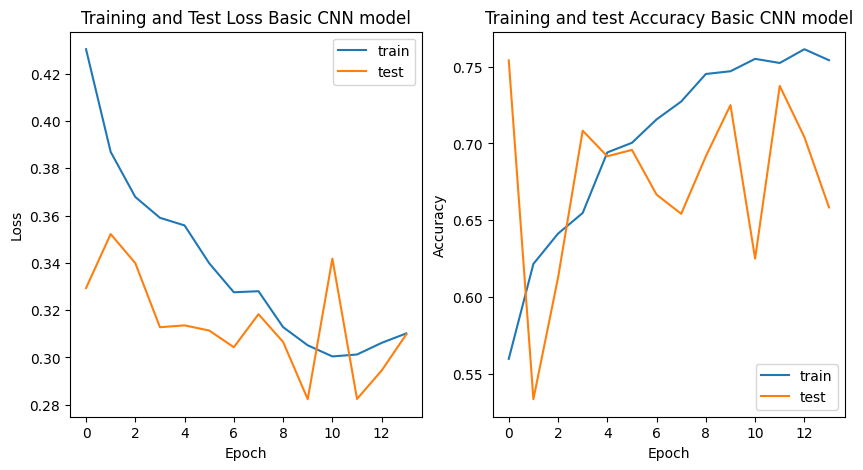

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss Basic CNN model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy Basic CNN model')
ax[1].legend()
plt.show()

## Test performance Basic CNN model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.3097845951716105
Accuracy: 0.6583333333333333

Specificity: 0.7380952380952381
Sensitivity: 0.6414141414141414
g_mean: 0.6880586627786351

Precision: 0.9202898550724637
Recall: 0.6414141414141414
F1-score: 0.7559523809523809
F1_score_macro: 0.5932539682539683
AUC-ROC: 0.7573352573352574

              precision    recall  f1-score   support

         0.0       0.30      0.74      0.43        42
         1.0       0.92      0.64      0.76       198

    accuracy                           0.66       240
   macro avg       0.61      0.69      0.59       240
weighted avg       0.81      0.66      0.70       240



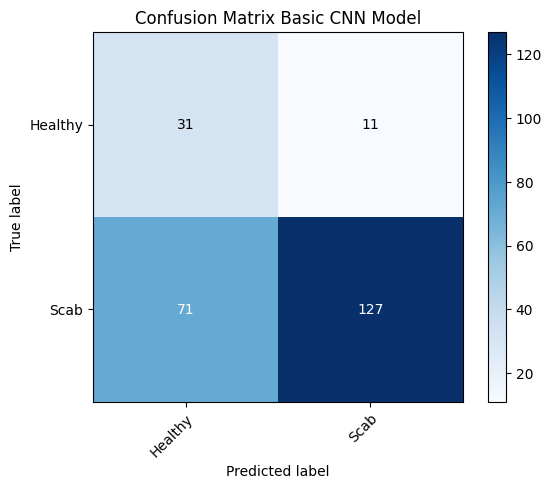

In [ ]:
import matplotlib.pyplot as plt

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix Basic CNN Model")
plt.show()

# ResNet50 model

In [ ]:
timm.list_models('*resnet50*', pretrained=True) # 'resnet50.a1_in1k', (resnet pretrained on imagenet 1k with input size 224x224)

['cspresnet50.ra_in1k',
 'ecaresnet50d.miil_in1k',
 'ecaresnet50d_pruned.miil_in1k',
 'ecaresnet50t.a1_in1k',
 'ecaresnet50t.a2_in1k',
 'ecaresnet50t.a3_in1k',
 'ecaresnet50t.ra2_in1k',
 'gcresnet50t.ra2_in1k',
 'lambda_resnet50ts.a1h_in1k',
 'legacy_seresnet50.in1k',
 'nf_resnet50.ra2_in1k',
 'resnet50.a1_in1k',
 'resnet50.a1h_in1k',
 'resnet50.a2_in1k',
 'resnet50.a3_in1k',
 'resnet50.am_in1k',
 'resnet50.b1k_in1k',
 'resnet50.b2k_in1k',
 'resnet50.bt_in1k',
 'resnet50.c1_in1k',
 'resnet50.c2_in1k',
 'resnet50.d_in1k',
 'resnet50.fb_ssl_yfcc100m_ft_in1k',
 'resnet50.fb_swsl_ig1b_ft_in1k',
 'resnet50.gluon_in1k',
 'resnet50.ra_in1k',
 'resnet50.ram_in1k',
 'resnet50.tv2_in1k',
 'resnet50.tv_in1k',
 'resnet50_gn.a1h_in1k',
 'resnet50c.gluon_in1k',
 'resnet50d.a1_in1k',
 'resnet50d.a2_in1k',
 'resnet50d.a3_in1k',
 'resnet50d.gluon_in1k',
 'resnet50d.ra2_in1k',
 'resnet50s.gluon_in1k',
 'seresnet50.a1_in1k',
 'seresnet50.a2_in1k',
 'seresnet50.a3_in1k',
 'seresnet50.ra2_in1k',
 'wide_res

## Do hyperparameter tuning ResNet50 model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):
  model = timm.create_model('resnet50.a1_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.fc.in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.fc = nn.Sequential(*head)

  for param in model.fc.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f} %"
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-13 21:18:55,119] A new study created in memory with name: no-name-65ffbcd9-d492-4f30-add6-3ed2c434e133


Epoch [1/100], Train Loss: 0.4157, Train Accuracy: 0.5149% Train specificity: 0.6048, Train sensitivity: 0.4771 Train g_mean: 0.5372% ----> Valid Loss: 0.3615, Valid Accuracy: 0.3080 %Valid specificity: 1.0000, Valid sensitivity: 0.1633 Valid g_mean: 0.4041
Epoch [2/100], Train Loss: 0.3718, Train Accuracy: 0.6547% Train specificity: 0.6976, Train sensitivity: 0.6367 Train g_mean: 0.6664% ----> Valid Loss: 0.2989, Valid Accuracy: 0.8270 %Valid specificity: 0.3171, Valid sensitivity: 0.9337 Valid g_mean: 0.5441
Epoch [3/100], Train Loss: 0.3749, Train Accuracy: 0.6894% Train specificity: 0.6169, Train sensitivity: 0.7199 Train g_mean: 0.6664% ----> Valid Loss: 0.4641, Valid Accuracy: 0.1941 %Valid specificity: 1.0000, Valid sensitivity: 0.0255 Valid g_mean: 0.1597
Epoch [4/100], Train Loss: 0.3832, Train Accuracy: 0.6045% Train specificity: 0.6855, Train sensitivity: 0.5705 Train g_mean: 0.6253% ----> Valid Loss: 0.3113, Valid Accuracy: 0.7257 %Valid specificity: 0.7073, Valid sensitivi

[I 2023-06-13 22:57:56,815] Trial 0 finished with value: 0.539273888233625 and parameters: {'first_neuron': 768, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.00252326364422698, 'weightdecay': 0.0029586172018584373, 'use_pos_weight': True}. Best is trial 0 with value: 0.539273888233625.


Epoch [18/100], Train Loss: 0.2964, Train Accuracy: 0.7622% Train specificity: 0.7540, Train sensitivity: 0.7657 Train g_mean: 0.7598% ----> Valid Loss: 0.4146, Valid Accuracy: 0.4135 %Valid specificity: 1.0000, Valid sensitivity: 0.2908 Valid g_mean: 0.5393
Early stopping criterion met at epoch 17
Epoch [1/100], Train Loss: 0.4382, Train Accuracy: 0.5687% Train specificity: 0.5806, Train sensitivity: 0.5637 Train g_mean: 0.5721% ----> Valid Loss: 0.3358, Valid Accuracy: 0.8228 %Valid specificity: 0.4390, Valid sensitivity: 0.9031 Valid g_mean: 0.6297
Epoch [2/100], Train Loss: 0.3840, Train Accuracy: 0.6368% Train specificity: 0.5887, Train sensitivity: 0.6570 Train g_mean: 0.6219% ----> Valid Loss: 0.3060, Valid Accuracy: 0.8270 %Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.3791, Train Accuracy: 0.6523% Train specificity: 0.6250, Train sensitivity: 0.6638 Train g_mean: 0.6441% ----> Valid Loss: 0.4777, Valid Accuracy: 0.1730 %

[I 2023-06-13 23:42:15,151] Trial 1 finished with value: 0.555527901529527 and parameters: {'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.0012800864642942796, 'weightdecay': 0.005107115498407277, 'use_pos_weight': True}. Best is trial 1 with value: 0.555527901529527.


Epoch [9/100], Train Loss: 0.3496, Train Accuracy: 0.6953% Train specificity: 0.7016, Train sensitivity: 0.6927 Train g_mean: 0.6971% ----> Valid Loss: 0.3586, Valid Accuracy: 0.4304 %Valid specificity: 0.9756, Valid sensitivity: 0.3163 Valid g_mean: 0.5555
Early stopping criterion met at epoch 8
Epoch [1/100], Train Loss: 0.6075, Train Accuracy: 0.6894% Train specificity: 0.0363, Train sensitivity: 0.9643 Train g_mean: 0.1871% ----> Valid Loss: 0.5229, Valid Accuracy: 0.8270 %Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.5889, Train Accuracy: 0.7037% Train specificity: 0.0000, Train sensitivity: 1.0000 Train g_mean: 0.0000% ----> Valid Loss: 0.5421, Valid Accuracy: 0.8270 %Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.5832, Train Accuracy: 0.7037% Train specificity: 0.0000, Train sensitivity: 1.0000 Train g_mean: 0.0000% ----> Valid Loss: 0.5034, Valid Accuracy: 0.8270 %Va

[I 2023-06-14 00:21:30,311] Trial 2 finished with value: 0.2691172450584589 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.00011586340612238657, 'weightdecay': 0.0013967603585816543, 'use_pos_weight': False}. Best is trial 1 with value: 0.555527901529527.


Epoch [8/100], Train Loss: 0.5461, Train Accuracy: 0.7157% Train specificity: 0.0524, Train sensitivity: 0.9949 Train g_mean: 0.2284% ----> Valid Loss: 0.5065, Valid Accuracy: 0.8312 %Valid specificity: 0.0732, Valid sensitivity: 0.9898 Valid g_mean: 0.2691
Early stopping criterion met at epoch 7
Epoch [1/100], Train Loss: 0.4086, Train Accuracy: 0.5687% Train specificity: 0.4677, Train sensitivity: 0.6112 Train g_mean: 0.5347% ----> Valid Loss: 0.3653, Valid Accuracy: 0.2743 %Valid specificity: 1.0000, Valid sensitivity: 0.1224 Valid g_mean: 0.3499
Epoch [2/100], Train Loss: 0.3872, Train Accuracy: 0.6010% Train specificity: 0.6371, Train sensitivity: 0.5857 Train g_mean: 0.6109% ----> Valid Loss: 0.3112, Valid Accuracy: 0.7679 %Valid specificity: 0.5854, Valid sensitivity: 0.8061 Valid g_mean: 0.6869
Epoch [3/100], Train Loss: 0.3534, Train Accuracy: 0.6834% Train specificity: 0.7177, Train sensitivity: 0.6689 Train g_mean: 0.6929% ----> Valid Loss: 0.3667, Valid Accuracy: 0.4093 %Va

[I 2023-06-14 01:47:35,866] Trial 3 finished with value: 0.7250066510740043 and parameters: {'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 0.0013328332405455185, 'weightdecay': 0.0038996291647017205, 'use_pos_weight': True}. Best is trial 3 with value: 0.7250066510740043.


Epoch [16/100], Train Loss: 0.2311, Train Accuracy: 0.8136% Train specificity: 0.7984, Train sensitivity: 0.8200 Train g_mean: 0.8091% ----> Valid Loss: 0.2709, Valid Accuracy: 0.6920 %Valid specificity: 0.7805, Valid sensitivity: 0.6735 Valid g_mean: 0.7250
Early stopping criterion met at epoch 15
Epoch [1/100], Train Loss: 0.4099, Train Accuracy: 0.5890% Train specificity: 0.4516, Train sensitivity: 0.6469 Train g_mean: 0.5405% ----> Valid Loss: 0.3573, Valid Accuracy: 0.7173 %Valid specificity: 0.6098, Valid sensitivity: 0.7398 Valid g_mean: 0.6716
Epoch [2/100], Train Loss: 0.3996, Train Accuracy: 0.7431% Train specificity: 0.2823, Train sensitivity: 0.9372 Train g_mean: 0.5143% ----> Valid Loss: 0.3645, Valid Accuracy: 0.2743 %Valid specificity: 1.0000, Valid sensitivity: 0.1224 Valid g_mean: 0.3499
Epoch [3/100], Train Loss: 0.3885, Train Accuracy: 0.6464% Train specificity: 0.7903, Train sensitivity: 0.5857 Train g_mean: 0.6804% ----> Valid Loss: 0.3383, Valid Accuracy: 0.7300 %

[I 2023-06-14 02:47:21,610] Trial 4 finished with value: 0.6422761602324863 and parameters: {'first_neuron': 128, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.0002906534908644687, 'weightdecay': 0.0031641488435897526, 'use_pos_weight': True}. Best is trial 3 with value: 0.7250066510740043.


Epoch [12/100], Train Loss: 0.3142, Train Accuracy: 0.7240% Train specificity: 0.7460, Train sensitivity: 0.7148 Train g_mean: 0.7302% ----> Valid Loss: 0.3370, Valid Accuracy: 0.5232 %Valid specificity: 0.9512, Valid sensitivity: 0.4337 Valid g_mean: 0.6423
Early stopping criterion met at epoch 11
Epoch [1/100], Train Loss: 0.5451, Train Accuracy: 0.5878% Train specificity: 0.4597, Train sensitivity: 0.6418 Train g_mean: 0.5431% ----> Valid Loss: 0.3523, Valid Accuracy: 0.6498 %Valid specificity: 0.8293, Valid sensitivity: 0.6122 Valid g_mean: 0.7125
Epoch [2/100], Train Loss: 0.4008, Train Accuracy: 0.6141% Train specificity: 0.6129, Train sensitivity: 0.6146 Train g_mean: 0.6138% ----> Valid Loss: 0.3246, Valid Accuracy: 0.8270 %Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.3898, Train Accuracy: 0.6523% Train specificity: 0.6169, Train sensitivity: 0.6672 Train g_mean: 0.6416% ----> Valid Loss: 0.3250, Valid Accuracy: 0.7806 %

[I 2023-06-14 04:58:48,433] Trial 5 finished with value: 0.5532833351724881 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.0026134340748596957, 'weightdecay': 0.0025750028689195486, 'use_pos_weight': True}. Best is trial 3 with value: 0.7250066510740043.


Epoch [26/100], Train Loss: 0.2834, Train Accuracy: 0.7957% Train specificity: 0.7984, Train sensitivity: 0.7946 Train g_mean: 0.7965% ----> Valid Loss: 0.3814, Valid Accuracy: 0.4262 %Valid specificity: 1.0000, Valid sensitivity: 0.3061 Valid g_mean: 0.5533
Early stopping criterion met at epoch 25
Epoch [1/100], Train Loss: 0.4841, Train Accuracy: 0.5054% Train specificity: 0.5444, Train sensitivity: 0.4890 Train g_mean: 0.5159% ----> Valid Loss: 0.3344, Valid Accuracy: 0.8565 %Valid specificity: 0.3902, Valid sensitivity: 0.9541 Valid g_mean: 0.6102
Epoch [2/100], Train Loss: 0.3813, Train Accuracy: 0.6237% Train specificity: 0.6694, Train sensitivity: 0.6044 Train g_mean: 0.6361% ----> Valid Loss: 0.3040, Valid Accuracy: 0.8354 %Valid specificity: 0.1463, Valid sensitivity: 0.9796 Valid g_mean: 0.3786
Epoch [3/100], Train Loss: 0.3681, Train Accuracy: 0.6882% Train specificity: 0.6492, Train sensitivity: 0.7046 Train g_mean: 0.6763% ----> Valid Loss: 0.5223, Valid Accuracy: 0.1730 %

[I 2023-06-14 06:00:21,752] Trial 6 finished with value: 0.24743582965269675 and parameters: {'first_neuron': 768, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.0008456404833983172, 'weightdecay': 0.0015930405038723418, 'use_pos_weight': True}. Best is trial 3 with value: 0.7250066510740043.


Epoch [13/100], Train Loss: 0.2962, Train Accuracy: 0.7706% Train specificity: 0.7944, Train sensitivity: 0.7606 Train g_mean: 0.7773% ----> Valid Loss: 0.5320, Valid Accuracy: 0.2236 %Valid specificity: 1.0000, Valid sensitivity: 0.0612 Valid g_mean: 0.2474
Early stopping criterion met at epoch 12
Epoch [1/100], Train Loss: 0.4045, Train Accuracy: 0.5663% Train specificity: 0.5847, Train sensitivity: 0.5586 Train g_mean: 0.5715% ----> Valid Loss: 0.3524, Valid Accuracy: 0.6076 %Valid specificity: 0.7561, Valid sensitivity: 0.5765 Valid g_mean: 0.6602
Epoch [2/100], Train Loss: 0.3870, Train Accuracy: 0.6619% Train specificity: 0.5605, Train sensitivity: 0.7046 Train g_mean: 0.6284% ----> Valid Loss: 0.3487, Valid Accuracy: 0.4937 %Valid specificity: 0.9512, Valid sensitivity: 0.3980 Valid g_mean: 0.6153
Epoch [3/100], Train Loss: 0.3648, Train Accuracy: 0.6894% Train specificity: 0.7056, Train sensitivity: 0.6825 Train g_mean: 0.6940% ----> Valid Loss: 0.3462, Valid Accuracy: 0.4768 %

[I 2023-06-14 06:37:43,575] Trial 7 pruned. 


Epoch [8/100], Train Loss: 0.2905, Train Accuracy: 0.7682% Train specificity: 0.8226, Train sensitivity: 0.7453 Train g_mean: 0.7830% ----> Valid Loss: 0.3403, Valid Accuracy: 0.5316 %Valid specificity: 0.9268, Valid sensitivity: 0.4490 Valid g_mean: 0.6451
Epoch [1/100], Train Loss: 0.5989, Train Accuracy: 0.7049% Train specificity: 0.0040, Train sensitivity: 1.0000 Train g_mean: 0.0635% ----> Valid Loss: 0.5421, Valid Accuracy: 0.8270 %Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000


[I 2023-06-14 06:47:40,170] Trial 8 pruned. 


Epoch [2/100], Train Loss: 0.5826, Train Accuracy: 0.7037% Train specificity: 0.0000, Train sensitivity: 1.0000 Train g_mean: 0.0000% ----> Valid Loss: 0.5479, Valid Accuracy: 0.8270 %Valid specificity: 0.0244, Valid sensitivity: 0.9949 Valid g_mean: 0.1558
Epoch [1/100], Train Loss: 0.4531, Train Accuracy: 0.6069% Train specificity: 0.6008, Train sensitivity: 0.6095 Train g_mean: 0.6051% ----> Valid Loss: 0.5945, Valid Accuracy: 0.1730 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000


[I 2023-06-14 06:57:49,476] Trial 9 pruned. 


Epoch [2/100], Train Loss: 0.4090, Train Accuracy: 0.5759% Train specificity: 0.6129, Train sensitivity: 0.5603 Train g_mean: 0.5860% ----> Valid Loss: 0.3174, Valid Accuracy: 0.7384 %Valid specificity: 0.5854, Valid sensitivity: 0.7704 Valid g_mean: 0.6715
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  3
  Number of complete trials:  7
Best trial:
  Value:  0.7250066510740043
  Params: 
    first_neuron: 512
    drop_out: 0.5
    optimizer: AdamW
    lr: 0.0013328332405455185
    weightdecay: 0.0038996291647017205
    use_pos_weight: True


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.539274,2023-06-13 21:18:55.125630,2023-06-13 22:57:56.815067,0 days 01:39:01.689437,0.3,768,0.002523,Adam,True,0.002959,COMPLETE
1,1,0.555528,2023-06-13 22:57:56.816523,2023-06-13 23:42:15.151178,0 days 00:44:18.334655,0.3,256,0.001280,RMSprop,True,0.005107,COMPLETE
2,2,0.269117,2023-06-13 23:42:15.152692,2023-06-14 00:21:30.311530,0 days 00:39:15.158838,0.3,128,0.000116,RMSprop,False,0.001397,COMPLETE
3,3,0.725007,2023-06-14 00:21:30.313073,2023-06-14 01:47:35.866205,0 days 01:26:05.553132,0.5,512,0.001333,AdamW,True,0.003900,COMPLETE
4,4,0.642276,2023-06-14 01:47:35.867781,2023-06-14 02:47:21.610167,0 days 00:59:45.742386,0.0,128,0.000291,Adam,True,0.003164,COMPLETE
5,5,0.553283,2023-06-14 02:47:21.611751,2023-06-14 04:58:48.432930,0 days 02:11:26.821179,0.3,128,0.002613,RMSprop,True,0.002575,COMPLETE
6,6,0.247436,2023-06-14 04:58:48.435514,2023-06-14 06:00:21.752299,0 days 01:01:33.316785,0.5,768,0.000846,RMSprop,True,0.001593,COMPLETE
7,7,0.671821,2023-06-14 06:00:21.753922,2023-06-14 06:37:43.575023,0 days 00:37:21.821101,0.3,512,0.000382,AdamW,True,0.009503,PRUNED
8,8,0.000000,2023-06-14 06:37:43.577349,2023-06-14 06:47:40.169994,0 days 00:09:56.592645,0.5,768,0.000326,Adam,False,0.001028,PRUNED
9,9,0.000000,2023-06-14 06:47:40.171533,2023-06-14 06:57:49.476186,0 days 00:10:09.304653,0.0,768,0.008925,Adam,True,0.002270,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

## Train the ResNet50 model with the best hyperparameters (on combined training and validation dataset)

In [ ]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 512
best_dropout = 0.5
best_optimizer = 'AdamW'
best_lr = 0.001333
epochs = 16
weight_decay = 0.003900
use_pos_weight = True



def define_model():
  model = timm.create_model('resnet50.a1_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False


  num_in_features = model.fc.in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.fc = nn.Sequential(*head)

  for param in model.fc.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/16], Train_val Loss: 0.4026, Train_val Accuracy: 0.6072%, Train_val specificity: 0.5152, Train_val sensitivity: 0.6459, Train_val g_mean: 0.5768% ----> Test Loss: 0.3596, Test Accuracy: 0.3500%, Test specificity: 0.9762, Test sensitivity: 0.2172, Test g_mean: 0.4604
Epoch [2/16], Train_val Loss: 0.3696, Train_val Accuracy: 0.6386%, Train_val specificity: 0.6939, Train_val sensitivity: 0.6153, Train_val g_mean: 0.6534% ----> Test Loss: 0.2905, Test Accuracy: 0.7833%, Test specificity: 0.7619, Test sensitivity: 0.7879, Test g_mean: 0.7748
Epoch [3/16], Train_val Loss: 0.3291, Train_val Accuracy: 0.7444%, Train_val specificity: 0.7091, Train_val sensitivity: 0.7592, Train_val g_mean: 0.7337% ----> Test Loss: 0.3502, Test Accuracy: 0.4667%, Test specificity: 0.9286, Test sensitivity: 0.3687, Test g_mean: 0.5851
Epoch [4/16], Train_val Loss: 0.3399, Train_val Accuracy: 0.6942%, Train_val specificity: 0.7152, Train_val sensitivity: 0.6854, Train_val g_mean: 0.7001% ----> Test Loss: 

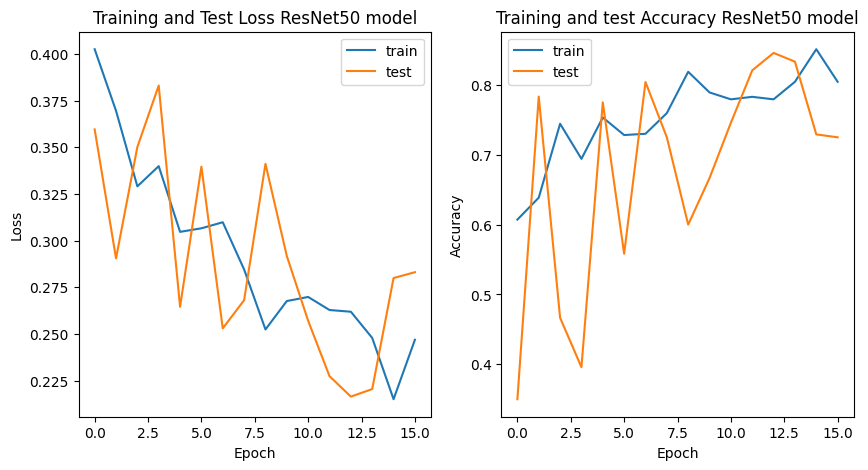

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss ResNet50 model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy ResNet50 model')
ax[1].legend()
plt.show()

## Test performance ResNet50 model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.2830834190050761
Accuracy: 0.725

Specificity: 0.9285714285714286
Sensitivity: 0.6818181818181818
g_mean: 0.7956864226043342

Precision: 0.9782608695652174
Recall: 0.6818181818181818
F1-score: 0.8035714285714285
F1_score_macro: 0.6726190476190477
AUC-ROC: 0.8692881192881193

              precision    recall  f1-score   support

         0.0       0.38      0.93      0.54        42
         1.0       0.98      0.68      0.80       198

    accuracy                           0.73       240
   macro avg       0.68      0.81      0.67       240
weighted avg       0.87      0.72      0.76       240



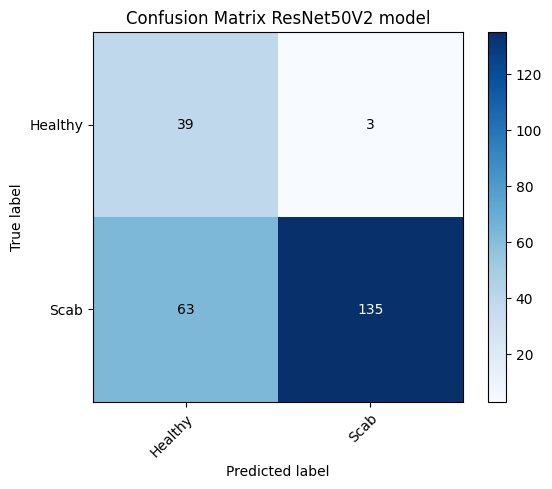

In [ ]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ResNet50 model")
plt.show()

# EfficientNetV2B0 model

In [ ]:
timm.list_models('*efficientnetv2_b0*', pretrained=True)
# 'tf_efficientnetv2_b0.in1k' (fficientnetv2 pretrained on imagenet 1k with input size 224x224)

['tf_efficientnetv2_b0.in1k']

## Do hyperparameter tuning EfficientNetV2B0 model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):
  model = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.classifier = nn.Sequential(*head)

  for param in model.classifier.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}% "
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-14 12:55:23,939] A new study created in memory with name: no-name-617011ec-07ce-4120-be47-faf6043461a2


Epoch [1/100], Train Loss: 0.3513, Train Accuracy: 0.7097% Train specificity: 0.6048, Train sensitivity: 0.7538 Train g_mean: 0.6752% ----> Valid Loss: 0.2857, Valid Accuracy: 0.6962% Valid specificity: 0.8293, Valid sensitivity: 0.6684 Valid g_mean: 0.7445
Epoch [2/100], Train Loss: 0.2564, Train Accuracy: 0.7981% Train specificity: 0.8185, Train sensitivity: 0.7895 Train g_mean: 0.8039% ----> Valid Loss: 0.3001, Valid Accuracy: 0.6456% Valid specificity: 0.8780, Valid sensitivity: 0.5969 Valid g_mean: 0.7240
Epoch [3/100], Train Loss: 0.2307, Train Accuracy: 0.8375% Train specificity: 0.8629, Train sensitivity: 0.8268 Train g_mean: 0.8447% ----> Valid Loss: 0.3881, Valid Accuracy: 0.5612% Valid specificity: 0.9268, Valid sensitivity: 0.4847 Valid g_mean: 0.6702
Epoch [4/100], Train Loss: 0.2280, Train Accuracy: 0.8268% Train specificity: 0.8548, Train sensitivity: 0.8149 Train g_mean: 0.8347% ----> Valid Loss: 0.2444, Valid Accuracy: 0.7890% Valid specificity: 0.7073, Valid sensitivi

[I 2023-06-14 14:27:32,291] Trial 0 finished with value: 0.7978162080590443 and parameters: {'first_neuron': 768, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.0013141133827799082, 'weightdecay': 0.0011264850496672011, 'use_pos_weight': True}. Best is trial 0 with value: 0.7978162080590443.


Epoch [17/100], Train Loss: 0.1449, Train Accuracy: 0.8984% Train specificity: 0.9113, Train sensitivity: 0.8930 Train g_mean: 0.9021% ----> Valid Loss: 0.2127, Valid Accuracy: 0.8270% Valid specificity: 0.7561, Valid sensitivity: 0.8418 Valid g_mean: 0.7978
Early stopping criterion met at epoch 16
Epoch [1/100], Train Loss: 0.3533, Train Accuracy: 0.7037% Train specificity: 0.6653, Train sensitivity: 0.7199 Train g_mean: 0.6921% ----> Valid Loss: 0.3523, Valid Accuracy: 0.5401% Valid specificity: 0.9268, Valid sensitivity: 0.4592 Valid g_mean: 0.6524
Epoch [2/100], Train Loss: 0.2700, Train Accuracy: 0.7730% Train specificity: 0.8347, Train sensitivity: 0.7470 Train g_mean: 0.7896% ----> Valid Loss: 0.2566, Valid Accuracy: 0.7679% Valid specificity: 0.8049, Valid sensitivity: 0.7602 Valid g_mean: 0.7822
Epoch [3/100], Train Loss: 0.2358, Train Accuracy: 0.8088% Train specificity: 0.8468, Train sensitivity: 0.7929 Train g_mean: 0.8194% ----> Valid Loss: 0.2418, Valid Accuracy: 0.7848% 

[I 2023-06-14 16:14:15,486] Trial 1 finished with value: 0.8405774402464471 and parameters: {'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.002362972646961394, 'weightdecay': 0.0025520091794757433, 'use_pos_weight': True}. Best is trial 1 with value: 0.8405774402464471.


Epoch [21/100], Train Loss: 0.0530, Train Accuracy: 0.9713% Train specificity: 0.9718, Train sensitivity: 0.9711 Train g_mean: 0.9715% ----> Valid Loss: 0.2110, Valid Accuracy: 0.8481% Valid specificity: 0.8293, Valid sensitivity: 0.8520 Valid g_mean: 0.8406
Early stopping criterion met at epoch 20
Epoch [1/100], Train Loss: 0.6010, Train Accuracy: 0.7001% Train specificity: 0.0323, Train sensitivity: 0.9813 Train g_mean: 0.1779% ----> Valid Loss: 0.5067, Valid Accuracy: 0.8481% Valid specificity: 0.1951, Valid sensitivity: 0.9847 Valid g_mean: 0.4383
Epoch [2/100], Train Loss: 0.5118, Train Accuracy: 0.7611% Train specificity: 0.2419, Train sensitivity: 0.9796 Train g_mean: 0.4868% ----> Valid Loss: 0.4885, Valid Accuracy: 0.8439% Valid specificity: 0.4634, Valid sensitivity: 0.9235 Valid g_mean: 0.6542
Epoch [3/100], Train Loss: 0.4501, Train Accuracy: 0.7981% Train specificity: 0.4315, Train sensitivity: 0.9525 Train g_mean: 0.6410% ----> Valid Loss: 0.5074, Valid Accuracy: 0.7595% 

[I 2023-06-14 17:18:12,368] Trial 2 finished with value: 0.7503110355543653 and parameters: {'first_neuron': 768, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.0003919745965180957, 'weightdecay': 0.002484652787317349, 'use_pos_weight': False}. Best is trial 1 with value: 0.8405774402464471.


Epoch [13/100], Train Loss: 0.2742, Train Accuracy: 0.8865% Train specificity: 0.7823, Train sensitivity: 0.9304 Train g_mean: 0.8531% ----> Valid Loss: 0.3668, Valid Accuracy: 0.8439% Valid specificity: 0.6341, Valid sensitivity: 0.8878 Valid g_mean: 0.7503
Early stopping criterion met at epoch 12
Epoch [1/100], Train Loss: 0.6051, Train Accuracy: 0.6977% Train specificity: 0.0000, Train sensitivity: 0.9915 Train g_mean: 0.0000% ----> Valid Loss: 0.4993, Valid Accuracy: 0.8397% Valid specificity: 0.0732, Valid sensitivity: 1.0000 Valid g_mean: 0.2705
Epoch [2/100], Train Loss: 0.5436, Train Accuracy: 0.7192% Train specificity: 0.0726, Train sensitivity: 0.9915 Train g_mean: 0.2683% ----> Valid Loss: 0.5204, Valid Accuracy: 0.8270% Valid specificity: 0.3902, Valid sensitivity: 0.9184 Valid g_mean: 0.5987
Epoch [3/100], Train Loss: 0.4948, Train Accuracy: 0.7622% Train specificity: 0.3145, Train sensitivity: 0.9508 Train g_mean: 0.5468% ----> Valid Loss: 0.5178, Valid Accuracy: 0.7722% 

[I 2023-06-14 19:38:18,067] Trial 3 finished with value: 0.7567515917576094 and parameters: {'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.00022563364859631675, 'weightdecay': 0.001509543764026674, 'use_pos_weight': False}. Best is trial 1 with value: 0.8405774402464471.


Epoch [29/100], Train Loss: 0.2306, Train Accuracy: 0.9152% Train specificity: 0.8266, Train sensitivity: 0.9525 Train g_mean: 0.8873% ----> Valid Loss: 0.3362, Valid Accuracy: 0.8565% Valid specificity: 0.6341, Valid sensitivity: 0.9031 Valid g_mean: 0.7568
Early stopping criterion met at epoch 28
Epoch [1/100], Train Loss: 0.4515, Train Accuracy: 0.6607% Train specificity: 0.6290, Train sensitivity: 0.6740 Train g_mean: 0.6511% ----> Valid Loss: 0.6538, Valid Accuracy: 0.2194% Valid specificity: 0.9756, Valid sensitivity: 0.0612 Valid g_mean: 0.2444
Epoch [2/100], Train Loss: 0.3021, Train Accuracy: 0.7634% Train specificity: 0.7823, Train sensitivity: 0.7555 Train g_mean: 0.7688% ----> Valid Loss: 0.5173, Valid Accuracy: 0.3291% Valid specificity: 1.0000, Valid sensitivity: 0.1888 Valid g_mean: 0.4345
Epoch [3/100], Train Loss: 0.2755, Train Accuracy: 0.7778% Train specificity: 0.8306, Train sensitivity: 0.7555 Train g_mean: 0.7922% ----> Valid Loss: 0.2530, Valid Accuracy: 0.8228% 

[I 2023-06-14 20:33:20,343] Trial 4 finished with value: 0.5354528979037921 and parameters: {'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.0019449997017046304, 'weightdecay': 0.0037403890855399772, 'use_pos_weight': True}. Best is trial 1 with value: 0.8405774402464471.


Epoch [11/100], Train Loss: 0.2167, Train Accuracy: 0.8351% Train specificity: 0.8710, Train sensitivity: 0.8200 Train g_mean: 0.8451% ----> Valid Loss: 0.3009, Valid Accuracy: 0.8608% Valid specificity: 0.2927, Valid sensitivity: 0.9796 Valid g_mean: 0.5355
Early stopping criterion met at epoch 10
Epoch [1/100], Train Loss: 0.5457, Train Accuracy: 0.7300% Train specificity: 0.2863, Train sensitivity: 0.9168 Train g_mean: 0.5123% ----> Valid Loss: 0.4682, Valid Accuracy: 0.8186% Valid specificity: 0.6585, Valid sensitivity: 0.8520 Valid g_mean: 0.7491
Epoch [2/100], Train Loss: 0.4094, Train Accuracy: 0.8196% Train specificity: 0.5444, Train sensitivity: 0.9355 Train g_mean: 0.7136% ----> Valid Loss: 0.5023, Valid Accuracy: 0.7384% Valid specificity: 0.7561, Valid sensitivity: 0.7347 Valid g_mean: 0.7453
Epoch [3/100], Train Loss: 0.3846, Train Accuracy: 0.8244% Train specificity: 0.6210, Train sensitivity: 0.9100 Train g_mean: 0.7517% ----> Valid Loss: 0.3903, Valid Accuracy: 0.8270% 

[I 2023-06-14 20:57:32,331] Trial 5 pruned. 


Epoch [5/100], Train Loss: 0.3265, Train Accuracy: 0.8650% Train specificity: 0.7097, Train sensitivity: 0.9304 Train g_mean: 0.8126% ----> Valid Loss: 0.4131, Valid Accuracy: 0.7932% Valid specificity: 0.6829, Valid sensitivity: 0.8163 Valid g_mean: 0.7467
Epoch [1/100], Train Loss: 0.4057, Train Accuracy: 0.3740% Train specificity: 0.9113, Train sensitivity: 0.1477 Train g_mean: 0.3669% ----> Valid Loss: 0.3651, Valid Accuracy: 0.2658% Valid specificity: 1.0000, Valid sensitivity: 0.1122 Valid g_mean: 0.3350


[I 2023-06-14 21:07:31,659] Trial 6 pruned. 


Epoch [2/100], Train Loss: 0.3936, Train Accuracy: 0.6296% Train specificity: 0.8105, Train sensitivity: 0.5535 Train g_mean: 0.6698% ----> Valid Loss: 0.3572, Valid Accuracy: 0.4219% Valid specificity: 0.9756, Valid sensitivity: 0.3061 Valid g_mean: 0.5465
Epoch [1/100], Train Loss: 0.3572, Train Accuracy: 0.6810% Train specificity: 0.6694, Train sensitivity: 0.6859 Train g_mean: 0.6776% ----> Valid Loss: 0.2646, Valid Accuracy: 0.7890% Valid specificity: 0.6341, Valid sensitivity: 0.8214 Valid g_mean: 0.7217
Epoch [2/100], Train Loss: 0.2997, Train Accuracy: 0.7336% Train specificity: 0.7419, Train sensitivity: 0.7301 Train g_mean: 0.7360% ----> Valid Loss: 0.3800, Valid Accuracy: 0.4810% Valid specificity: 0.9756, Valid sensitivity: 0.3776 Valid g_mean: 0.6069
Epoch [3/100], Train Loss: 0.3205, Train Accuracy: 0.7025% Train specificity: 0.7863, Train sensitivity: 0.6672 Train g_mean: 0.7243% ----> Valid Loss: 0.2499, Valid Accuracy: 0.8059% Valid specificity: 0.5366, Valid sensitivi

[I 2023-06-14 21:32:05,342] Trial 7 pruned. 


Epoch [5/100], Train Loss: 0.2636, Train Accuracy: 0.7897% Train specificity: 0.8145, Train sensitivity: 0.7793 Train g_mean: 0.7967% ----> Valid Loss: 0.2791, Valid Accuracy: 0.7046% Valid specificity: 0.7805, Valid sensitivity: 0.6888 Valid g_mean: 0.7332
Epoch [1/100], Train Loss: 0.3671, Train Accuracy: 0.7133% Train specificity: 0.7097, Train sensitivity: 0.7148 Train g_mean: 0.7122% ----> Valid Loss: 0.3457, Valid Accuracy: 0.5274% Valid specificity: 0.9512, Valid sensitivity: 0.4388 Valid g_mean: 0.6460
Epoch [2/100], Train Loss: 0.3160, Train Accuracy: 0.7873% Train specificity: 0.7903, Train sensitivity: 0.7861 Train g_mean: 0.7882% ----> Valid Loss: 0.3315, Valid Accuracy: 0.5823% Valid specificity: 0.9024, Valid sensitivity: 0.5153 Valid g_mean: 0.6819
Epoch [3/100], Train Loss: 0.2916, Train Accuracy: 0.7933% Train specificity: 0.8024, Train sensitivity: 0.7895 Train g_mean: 0.7959% ----> Valid Loss: 0.3158, Valid Accuracy: 0.6203% Valid specificity: 0.9024, Valid sensitivi

[I 2023-06-14 21:51:27,136] Trial 8 pruned. 


Epoch [4/100], Train Loss: 0.2769, Train Accuracy: 0.8005% Train specificity: 0.8024, Train sensitivity: 0.7997 Train g_mean: 0.8010% ----> Valid Loss: 0.2969, Valid Accuracy: 0.6793% Valid specificity: 0.8537, Valid sensitivity: 0.6429 Valid g_mean: 0.7408
Epoch [1/100], Train Loss: 0.5651, Train Accuracy: 0.7061% Train specificity: 0.0685, Train sensitivity: 0.9745 Train g_mean: 0.2585% ----> Valid Loss: 0.4475, Valid Accuracy: 0.8481% Valid specificity: 0.4390, Valid sensitivity: 0.9337 Valid g_mean: 0.6402
Epoch [2/100], Train Loss: 0.4551, Train Accuracy: 0.7885% Train specificity: 0.4960, Train sensitivity: 0.9117 Train g_mean: 0.6724% ----> Valid Loss: 0.4661, Valid Accuracy: 0.7890% Valid specificity: 0.7317, Valid sensitivity: 0.8010 Valid g_mean: 0.7656
Epoch [3/100], Train Loss: 0.3821, Train Accuracy: 0.8495% Train specificity: 0.6694, Train sensitivity: 0.9253 Train g_mean: 0.7870% ----> Valid Loss: 0.4242, Valid Accuracy: 0.8143% Valid specificity: 0.6829, Valid sensitivi

[I 2023-06-14 22:15:00,510] Trial 9 pruned. 


Epoch [5/100], Train Loss: 0.2991, Train Accuracy: 0.8650% Train specificity: 0.7581, Train sensitivity: 0.9100 Train g_mean: 0.8306% ----> Valid Loss: 0.3826, Valid Accuracy: 0.8143% Valid specificity: 0.6585, Valid sensitivity: 0.8469 Valid g_mean: 0.7468
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  5
  Number of complete trials:  5
Best trial:
  Value:  0.8405774402464471
  Params: 
    first_neuron: 256
    drop_out: 0.3
    optimizer: AdamW
    lr: 0.002362972646961394
    weightdecay: 0.0025520091794757433
    use_pos_weight: True


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.797816,2023-06-14 12:55:23.942132,2023-06-14 14:27:32.291258,0 days 01:32:08.349126,0.3,768,0.001314,Adam,True,0.001126,COMPLETE
1,1,0.840577,2023-06-14 14:27:32.302060,2023-06-14 16:14:15.485722,0 days 01:46:43.183662,0.3,256,0.002363,AdamW,True,0.002552,COMPLETE
2,2,0.750311,2023-06-14 16:14:15.487408,2023-06-14 17:18:12.368527,0 days 01:03:56.881119,0.5,768,0.000392,Adam,False,0.002485,COMPLETE
3,3,0.756752,2023-06-14 17:18:12.370023,2023-06-14 19:38:18.067035,0 days 02:20:05.697012,0.3,512,0.000226,Adam,False,0.001510,COMPLETE
4,4,0.535453,2023-06-14 19:38:18.068506,2023-06-14 20:33:20.343298,0 days 00:55:02.274792,0.5,512,0.001945,RMSprop,True,0.003740,COMPLETE
5,5,0.764604,2023-06-14 20:33:20.345059,2023-06-14 20:57:32.331216,0 days 00:24:11.986157,0.5,256,0.000755,RMSprop,False,0.001340,PRUNED
6,6,0.335030,2023-06-14 20:57:32.332944,2023-06-14 21:07:31.659423,0 days 00:09:59.326479,0.3,128,0.000134,AdamW,True,0.003014,PRUNED
7,7,0.735910,2023-06-14 21:07:31.664498,2023-06-14 21:32:05.341951,0 days 00:24:33.677453,0.5,256,0.008616,Adam,True,0.003648,PRUNED
8,8,0.711668,2023-06-14 21:32:05.344256,2023-06-14 21:51:27.136024,0 days 00:19:21.791768,0.3,768,0.000123,RMSprop,True,0.002543,PRUNED
9,9,0.735233,2023-06-14 21:51:27.137649,2023-06-14 22:15:00.510528,0 days 00:23:33.372879,0.0,768,0.000562,AdamW,False,0.003135,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

## Train the EfficientNetV2B0 model with the best hyperparameters (on combined training and validation dataset)

In [ ]:
BATCHSIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 256
best_dropout = 0.3
best_optimizer = 'AdamW'
best_lr = 0.002363
epochs = 21
weightdecay = 0.002552
use_pos_weight = True


def define_model():
  model = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.classifier = nn.Sequential(*head)

  for param in model.classifier.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weightdecay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weightdecay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weightdecay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/21], Train_val Loss: 0.3317, Train_val Accuracy: 0.7247%, Train_val specificity: 0.7364, Train_val sensitivity: 0.7197, Train_val g_mean: 0.7280% ----> Test Loss: 0.3481, Test Accuracy: 0.5500%, Test specificity: 0.9524, Test sensitivity: 0.4646, Test g_mean: 0.6652
Epoch [2/21], Train_val Loss: 0.2529, Train_val Accuracy: 0.7767%, Train_val specificity: 0.8152, Train_val sensitivity: 0.7605, Train_val g_mean: 0.7874% ----> Test Loss: 0.2249, Test Accuracy: 0.7875%, Test specificity: 0.8810, Test sensitivity: 0.7677, Test g_mean: 0.8224
Epoch [3/21], Train_val Loss: 0.2204, Train_val Accuracy: 0.8233%, Train_val specificity: 0.8303, Train_val sensitivity: 0.8204, Train_val g_mean: 0.8253% ----> Test Loss: 0.2142, Test Accuracy: 0.8667%, Test specificity: 0.8333, Test sensitivity: 0.8737, Test g_mean: 0.8533
Epoch [4/21], Train_val Loss: 0.1864, Train_val Accuracy: 0.8574%, Train_val specificity: 0.8879, Train_val sensitivity: 0.8446, Train_val g_mean: 0.8660% ----> Test Loss: 

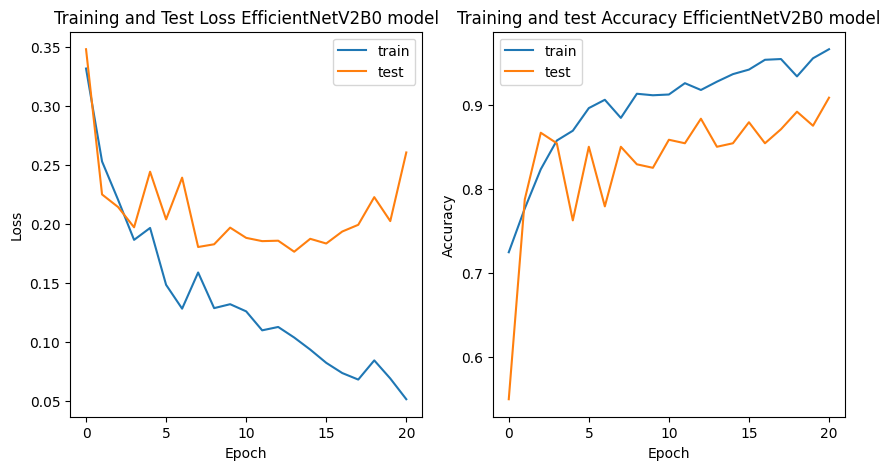

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss EfficientNetV2B0 model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy EfficientNetV2B0 model')
ax[1].legend()
plt.show()

## Test performance EfficientNetV2B0 model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.2605381033072869
Accuracy: 0.9083333333333333

Specificity: 0.6428571428571429
Sensitivity: 0.9646464646464646
g_mean: 0.787483250697988

Precision: 0.9271844660194175
Recall: 0.9646464646464646
F1-score: 0.9455445544554456
F1_score_macro: 0.8280354351224597
AUC-ROC: 0.905002405002405

              precision    recall  f1-score   support

         0.0       0.79      0.64      0.71        42
         1.0       0.93      0.96      0.95       198

    accuracy                           0.91       240
   macro avg       0.86      0.80      0.83       240
weighted avg       0.90      0.91      0.90       240



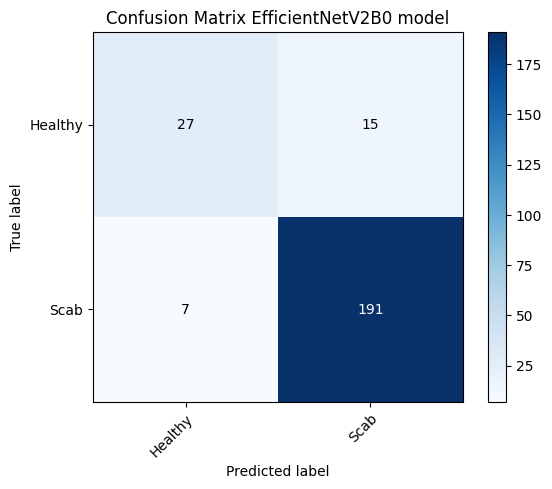

In [ ]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix EfficientNetV2B0 model")
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

# ConvNeXtTiny model

In [ ]:
timm.list_models('*convnext_tiny*', pretrained=True) # 'convnext_tiny.fb_in1k' (resnet pretrained on imagenet 1k with input size 224x224)

['convnext_tiny.fb_in1k',
 'convnext_tiny.fb_in22k',
 'convnext_tiny.fb_in22k_ft_in1k',
 'convnext_tiny.fb_in22k_ft_in1k_384',
 'convnext_tiny.in12k',
 'convnext_tiny.in12k_ft_in1k',
 'convnext_tiny.in12k_ft_in1k_384',
 'convnext_tiny_hnf.a2h_in1k']

## Do hyperparameter tuning ConvNeXtTiny model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):
  model = timm.create_model('convnext_tiny.fb_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False, num_workers=2)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}% "
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-16 19:17:59,926] A new study created in memory with name: no-name-a2d2ed66-f863-4b91-8c9d-603c769bc3d6


Epoch [1/100], Train Loss: 0.4047, Train Accuracy: 0.5532% Train specificity: 0.6250, Train sensitivity: 0.5229 Train g_mean: 0.5717% ----> Valid Loss: 0.3082, Valid Accuracy: 0.8228% Valid specificity: 0.1707, Valid sensitivity: 0.9592 Valid g_mean: 0.4047
Epoch [2/100], Train Loss: 0.3808, Train Accuracy: 0.6499% Train specificity: 0.6411, Train sensitivity: 0.6537 Train g_mean: 0.6474% ----> Valid Loss: 0.3633, Valid Accuracy: 0.4473% Valid specificity: 0.8537, Valid sensitivity: 0.3622 Valid g_mean: 0.5561
Epoch [3/100], Train Loss: 0.3757, Train Accuracy: 0.6440% Train specificity: 0.6492, Train sensitivity: 0.6418 Train g_mean: 0.6455% ----> Valid Loss: 0.3020, Valid Accuracy: 0.8270% Valid specificity: 0.3902, Valid sensitivity: 0.9184 Valid g_mean: 0.5987
Epoch [4/100], Train Loss: 0.3684, Train Accuracy: 0.6691% Train specificity: 0.6774, Train sensitivity: 0.6655 Train g_mean: 0.6715% ----> Valid Loss: 0.3072, Valid Accuracy: 0.7637% Valid specificity: 0.5122, Valid sensitivi

[I 2023-06-16 19:42:58,610] Trial 0 finished with value: 0.6530359471215591 and parameters: {'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.0024935912548396367, 'weightdecay': 0.008343856833392447, 'use_pos_weight': True}. Best is trial 0 with value: 0.6530359471215591.


Epoch [8/100], Train Loss: 0.3664, Train Accuracy: 0.6559% Train specificity: 0.6774, Train sensitivity: 0.6469 Train g_mean: 0.6620% ----> Valid Loss: 0.3143, Valid Accuracy: 0.7257% Valid specificity: 0.5610, Valid sensitivity: 0.7602 Valid g_mean: 0.6530
Early stopping criterion met at epoch 7
Epoch [1/100], Train Loss: 0.4014, Train Accuracy: 0.6093% Train specificity: 0.5847, Train sensitivity: 0.6197 Train g_mean: 0.6019% ----> Valid Loss: 0.3429, Valid Accuracy: 0.5485% Valid specificity: 0.7073, Valid sensitivity: 0.5153 Valid g_mean: 0.6037
Epoch [2/100], Train Loss: 0.3552, Train Accuracy: 0.6404% Train specificity: 0.6895, Train sensitivity: 0.6197 Train g_mean: 0.6537% ----> Valid Loss: 0.2773, Valid Accuracy: 0.8270% Valid specificity: 0.2683, Valid sensitivity: 0.9439 Valid g_mean: 0.5032
Epoch [3/100], Train Loss: 0.3402, Train Accuracy: 0.6667% Train specificity: 0.7460, Train sensitivity: 0.6333 Train g_mean: 0.6873% ----> Valid Loss: 0.2805, Valid Accuracy: 0.8312% Va

[I 2023-06-16 20:24:41,101] Trial 1 finished with value: 0.7372611524884796 and parameters: {'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.0020089188242495633, 'weightdecay': 0.0019411584385363324, 'use_pos_weight': True}. Best is trial 1 with value: 0.7372611524884796.


Epoch [16/100], Train Loss: 0.1636, Train Accuracy: 0.8769% Train specificity: 0.8669, Train sensitivity: 0.8812 Train g_mean: 0.8740% ----> Valid Loss: 0.2479, Valid Accuracy: 0.8692% Valid specificity: 0.5854, Valid sensitivity: 0.9286 Valid g_mean: 0.7373
Early stopping criterion met at epoch 15
Epoch [1/100], Train Loss: 0.6263, Train Accuracy: 0.7037% Train specificity: 0.0121, Train sensitivity: 0.9949 Train g_mean: 0.1097% ----> Valid Loss: 0.5013, Valid Accuracy: 0.8270% Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6042, Train Accuracy: 0.7037% Train specificity: 0.0000, Train sensitivity: 1.0000 Train g_mean: 0.0000% ----> Valid Loss: 0.4949, Valid Accuracy: 0.8270% Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.5922, Train Accuracy: 0.7037% Train specificity: 0.0000, Train sensitivity: 1.0000 Train g_mean: 0.0000% ----> Valid Loss: 0.4885, Valid Accuracy: 0.8270% 

[I 2023-06-16 22:36:48,853] Trial 2 finished with value: 0.6822064749508816 and parameters: {'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 0.00013043133980135456, 'weightdecay': 0.008841535350556066, 'use_pos_weight': False}. Best is trial 1 with value: 0.7372611524884796.


Epoch [52/100], Train Loss: 0.2981, Train Accuracy: 0.8817% Train specificity: 0.6613, Train sensitivity: 0.9745 Train g_mean: 0.8028% ----> Valid Loss: 0.3222, Valid Accuracy: 0.8734% Valid specificity: 0.4878, Valid sensitivity: 0.9541 Valid g_mean: 0.6822
Early stopping criterion met at epoch 51
Epoch [1/100], Train Loss: 0.4074, Train Accuracy: 0.5532% Train specificity: 0.4798, Train sensitivity: 0.5840 Train g_mean: 0.5294% ----> Valid Loss: 0.3532, Valid Accuracy: 0.4979% Valid specificity: 0.8293, Valid sensitivity: 0.4286 Valid g_mean: 0.5962
Epoch [2/100], Train Loss: 0.3839, Train Accuracy: 0.6535% Train specificity: 0.7218, Train sensitivity: 0.6248 Train g_mean: 0.6715% ----> Valid Loss: 0.3190, Valid Accuracy: 0.7384% Valid specificity: 0.5122, Valid sensitivity: 0.7857 Valid g_mean: 0.6344
Epoch [3/100], Train Loss: 0.3679, Train Accuracy: 0.6535% Train specificity: 0.7581, Train sensitivity: 0.6095 Train g_mean: 0.6797% ----> Valid Loss: 0.2977, Valid Accuracy: 0.8186% 

[I 2023-06-16 23:29:38,933] Trial 3 finished with value: 0.7536207606423009 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.0005503657392893023, 'weightdecay': 0.0023585240060935695, 'use_pos_weight': True}. Best is trial 3 with value: 0.7536207606423009.


Epoch [22/100], Train Loss: 0.2360, Train Accuracy: 0.8303% Train specificity: 0.8548, Train sensitivity: 0.8200 Train g_mean: 0.8373% ----> Valid Loss: 0.2402, Valid Accuracy: 0.8059% Valid specificity: 0.6829, Valid sensitivity: 0.8316 Valid g_mean: 0.7536
Early stopping criterion met at epoch 21
Epoch [1/100], Train Loss: 0.6289, Train Accuracy: 0.6834% Train specificity: 0.2339, Train sensitivity: 0.8727 Train g_mean: 0.4518% ----> Valid Loss: 0.5000, Valid Accuracy: 0.8143% Valid specificity: 0.3171, Valid sensitivity: 0.9184 Valid g_mean: 0.5396
Epoch [2/100], Train Loss: 0.5479, Train Accuracy: 0.7312% Train specificity: 0.2500, Train sensitivity: 0.9338 Train g_mean: 0.4832% ----> Valid Loss: 0.3853, Valid Accuracy: 0.8354% Valid specificity: 0.0976, Valid sensitivity: 0.9898 Valid g_mean: 0.3107
Epoch [3/100], Train Loss: 0.5003, Train Accuracy: 0.7503% Train specificity: 0.3105, Train sensitivity: 0.9355 Train g_mean: 0.5389% ----> Valid Loss: 0.3754, Valid Accuracy: 0.8523% 

[I 2023-06-17 00:04:53,726] Trial 4 finished with value: 0.46250664235876987 and parameters: {'first_neuron': 768, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.0038951147044869543, 'weightdecay': 0.0016960225114155962, 'use_pos_weight': False}. Best is trial 3 with value: 0.7536207606423009.


Epoch [14/100], Train Loss: 0.3151, Train Accuracy: 0.8650% Train specificity: 0.7056, Train sensitivity: 0.9321 Train g_mean: 0.8110% ----> Valid Loss: 0.3595, Valid Accuracy: 0.8439% Valid specificity: 0.2195, Valid sensitivity: 0.9745 Valid g_mean: 0.4625
Early stopping criterion met at epoch 13
Epoch [1/100], Train Loss: 0.6078, Train Accuracy: 0.6858% Train specificity: 0.0484, Train sensitivity: 0.9542 Train g_mean: 0.2149% ----> Valid Loss: 0.4393, Valid Accuracy: 0.8312% Valid specificity: 0.0244, Valid sensitivity: 1.0000 Valid g_mean: 0.1562


[I 2023-06-17 00:09:45,732] Trial 5 pruned. 


Epoch [2/100], Train Loss: 0.5607, Train Accuracy: 0.7252% Train specificity: 0.0927, Train sensitivity: 0.9915 Train g_mean: 0.3032% ----> Valid Loss: 0.4185, Valid Accuracy: 0.8312% Valid specificity: 0.0244, Valid sensitivity: 1.0000 Valid g_mean: 0.1562
Epoch [1/100], Train Loss: 0.5894, Train Accuracy: 0.7121% Train specificity: 0.1371, Train sensitivity: 0.9542 Train g_mean: 0.3617% ----> Valid Loss: 0.4154, Valid Accuracy: 0.8228% Valid specificity: 0.1220, Valid sensitivity: 0.9694 Valid g_mean: 0.3438


[I 2023-06-17 00:14:37,222] Trial 6 pruned. 


Epoch [2/100], Train Loss: 0.4723, Train Accuracy: 0.7826% Train specificity: 0.4315, Train sensitivity: 0.9304 Train g_mean: 0.6336% ----> Valid Loss: 0.3814, Valid Accuracy: 0.8312% Valid specificity: 0.1220, Valid sensitivity: 0.9796 Valid g_mean: 0.3456
Epoch [1/100], Train Loss: 0.6133, Train Accuracy: 0.7049% Train specificity: 0.0161, Train sensitivity: 0.9949 Train g_mean: 0.1267% ----> Valid Loss: 0.4389, Valid Accuracy: 0.8270% Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000


[I 2023-06-17 00:19:40,031] Trial 7 pruned. 


Epoch [2/100], Train Loss: 0.5756, Train Accuracy: 0.7073% Train specificity: 0.0323, Train sensitivity: 0.9915 Train g_mean: 0.1788% ----> Valid Loss: 0.4307, Valid Accuracy: 0.8270% Valid specificity: 0.0244, Valid sensitivity: 0.9949 Valid g_mean: 0.1558
Epoch [1/100], Train Loss: 0.4032, Train Accuracy: 0.5747% Train specificity: 0.5282, Train sensitivity: 0.5942 Train g_mean: 0.5603% ----> Valid Loss: 0.3230, Valid Accuracy: 0.7468% Valid specificity: 0.4634, Valid sensitivity: 0.8061 Valid g_mean: 0.6112
Epoch [2/100], Train Loss: 0.3722, Train Accuracy: 0.6332% Train specificity: 0.6411, Train sensitivity: 0.6299 Train g_mean: 0.6355% ----> Valid Loss: 0.3299, Valid Accuracy: 0.6076% Valid specificity: 0.7317, Valid sensitivity: 0.5816 Valid g_mean: 0.6524
Epoch [3/100], Train Loss: 0.3665, Train Accuracy: 0.6476% Train specificity: 0.7379, Train sensitivity: 0.6095 Train g_mean: 0.6706% ----> Valid Loss: 0.2975, Valid Accuracy: 0.8397% Valid specificity: 0.1220, Valid sensitivi

[I 2023-06-17 01:01:40,344] Trial 8 finished with value: 0.6772635479558502 and parameters: {'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.0003056473930188031, 'weightdecay': 0.006726300078425797, 'use_pos_weight': True}. Best is trial 3 with value: 0.7536207606423009.


Epoch [17/100], Train Loss: 0.2951, Train Accuracy: 0.7599% Train specificity: 0.7863, Train sensitivity: 0.7487 Train g_mean: 0.7673% ----> Valid Loss: 0.3315, Valid Accuracy: 0.5696% Valid specificity: 0.9268, Valid sensitivity: 0.4949 Valid g_mean: 0.6773
Early stopping criterion met at epoch 16
Epoch [1/100], Train Loss: 1.9526, Train Accuracy: 0.6655% Train specificity: 0.0806, Train sensitivity: 0.9117 Train g_mean: 0.2712% ----> Valid Loss: 0.4299, Valid Accuracy: 0.8270% Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000


[I 2023-06-17 01:06:31,967] Trial 9 pruned. 


Epoch [2/100], Train Loss: 0.5343, Train Accuracy: 0.7264% Train specificity: 0.1492, Train sensitivity: 0.9694 Train g_mean: 0.3803% ----> Valid Loss: 0.6057, Valid Accuracy: 0.6034% Valid specificity: 0.7073, Valid sensitivity: 0.5816 Valid g_mean: 0.6414
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  0.7536207606423009
  Params: 
    first_neuron: 128
    drop_out: 0.3
    optimizer: Adam
    lr: 0.0005503657392893023
    weightdecay: 0.0023585240060935695
    use_pos_weight: True


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.653036,2023-06-16 19:17:59.928076,2023-06-16 19:42:58.610564,0 days 00:24:58.682488,0.5,256,0.002494,Adam,True,0.008344,COMPLETE
1,1,0.737261,2023-06-16 19:42:58.612042,2023-06-16 20:24:41.100740,0 days 00:41:42.488698,0.3,512,0.002009,AdamW,True,0.001941,COMPLETE
2,2,0.682206,2023-06-16 20:24:41.102369,2023-06-16 22:36:48.852828,0 days 02:12:07.750459,0.5,256,0.000130,AdamW,False,0.008842,COMPLETE
3,3,0.753621,2023-06-16 22:36:48.854567,2023-06-16 23:29:38.933324,0 days 00:52:50.078757,0.3,128,0.000550,Adam,True,0.002359,COMPLETE
4,4,0.462507,2023-06-16 23:29:38.934999,2023-06-17 00:04:53.726222,0 days 00:35:14.791223,0.5,768,0.003895,Adam,False,0.001696,COMPLETE
5,5,0.156174,2023-06-17 00:04:53.728049,2023-06-17 00:09:45.732105,0 days 00:04:52.004056,0.0,256,0.000472,RMSprop,False,0.006040,PRUNED
6,6,0.343828,2023-06-17 00:09:45.733556,2023-06-17 00:14:37.222671,0 days 00:04:51.489115,0.3,768,0.004083,AdamW,False,0.009353,PRUNED
7,7,0.000000,2023-06-17 00:14:37.223991,2023-06-17 00:19:40.030956,0 days 00:05:02.806965,0.3,128,0.001846,AdamW,False,0.001697,PRUNED
8,8,0.677264,2023-06-17 00:19:40.032509,2023-06-17 01:01:40.344030,0 days 00:42:00.311521,0.3,512,0.000306,RMSprop,True,0.006726,COMPLETE
9,9,0.000000,2023-06-17 01:01:40.345942,2023-06-17 01:06:31.967767,0 days 00:04:51.621825,0.0,128,0.009711,RMSprop,False,0.001864,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

## Train the ConvNeXtTiny model with the best hyperparameters (on combined training and validation dataset)

In [ ]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 128
best_dropout = 0.3
best_optimizer = 'Adam'
best_lr = 0.000550
epochs = 22
weight_decay = 0.002359
use_pos_weight = True


def define_model():
  model = timm.create_model('convnext_tiny.fb_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/22], Train_val Loss: 0.4025, Train_val Accuracy: 0.5623%, Train_val specificity: 0.6606, Train_val sensitivity: 0.5210, Train_val g_mean: 0.5867% ----> Test Loss: 0.3287, Test Accuracy: 0.6792%, Test specificity: 0.6190, Test sensitivity: 0.6919, Test g_mean: 0.6545
Epoch [2/22], Train_val Loss: 0.3826, Train_val Accuracy: 0.6090%, Train_val specificity: 0.7242, Train_val sensitivity: 0.5605, Train_val g_mean: 0.6371% ----> Test Loss: 0.2951, Test Accuracy: 0.7792%, Test specificity: 0.4048, Test sensitivity: 0.8586, Test g_mean: 0.5895
Epoch [3/22], Train_val Loss: 0.3641, Train_val Accuracy: 0.6744%, Train_val specificity: 0.6667, Train_val sensitivity: 0.6777, Train_val g_mean: 0.6722% ----> Test Loss: 0.2830, Test Accuracy: 0.7583%, Test specificity: 0.6190, Test sensitivity: 0.7879, Test g_mean: 0.6984
Epoch [4/22], Train_val Loss: 0.3475, Train_val Accuracy: 0.7130%, Train_val specificity: 0.6545, Train_val sensitivity: 0.7376, Train_val g_mean: 0.6948% ----> Test Loss: 

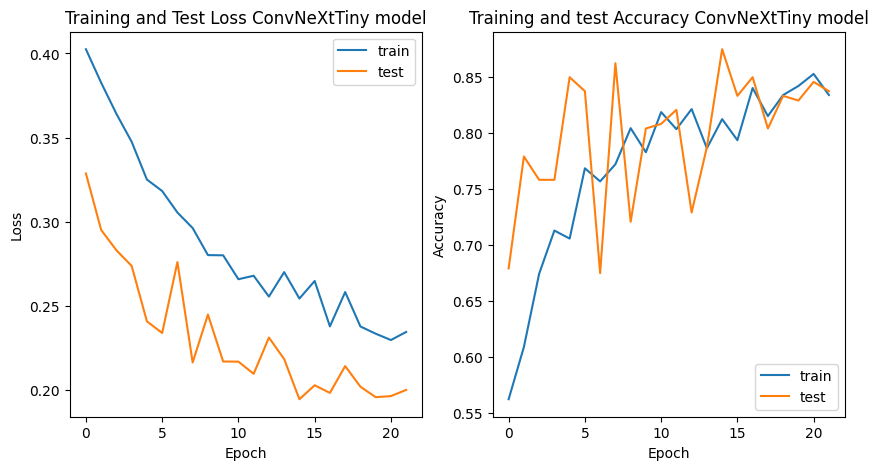

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss ConvNeXtTiny model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy ConvNeXtTiny model')
ax[1].legend()
plt.show()

## Test performance ConvNeXtTiny model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.1999980409940084
Accuracy: 0.8375

Specificity: 0.8095238095238095
Sensitivity: 0.8434343434343434
g_mean: 0.8263051390256403

Precision: 0.9542857142857143
Recall: 0.8434343434343434
F1-score: 0.8954423592493298
F1_score_macro: 0.7654781889704593
AUC-ROC: 0.9013949013949014

              precision    recall  f1-score   support

         0.0       0.52      0.81      0.64        42
         1.0       0.95      0.84      0.90       198

    accuracy                           0.84       240
   macro avg       0.74      0.83      0.77       240
weighted avg       0.88      0.84      0.85       240



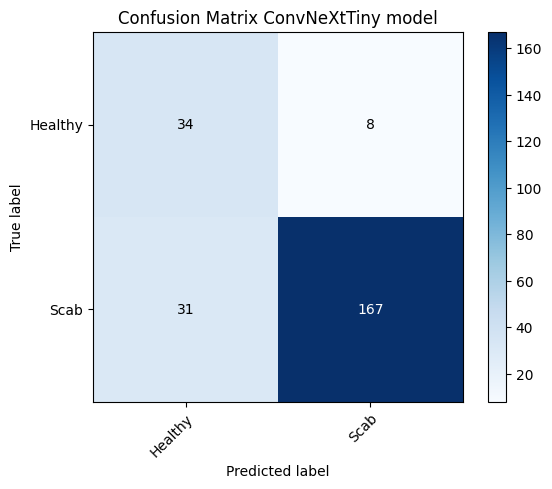

In [ ]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ConvNeXtTiny model")
plt.show()